# NLP Disaster Tweets Kaggle Mini-Project
## Introduction
The aim of this project is to build a deep learning model that predicts which Tweets are about real disasters and which one’s are not. The data set and challenge is provided by "Natural Language Processing with Disaster Tweets" kaggle competition. We will perform data cleaning, exploratory data analysis, implement RNN using keras library, build and evaluate our models.

## Data Source
Data is available at https://www.kaggle.com/c/nlp-getting-started/data and consists of train.csv and test.csv files.

Each sample has the text of a tweet, a keyword from that tweet and location that tweet was sent from. 

Columns in the data are:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Importing Libraries
We will start by importing necessary libraries. 

In [259]:
import math
from random import sample
import re 

import numpy as np 
import pandas as pd 


import nltk 
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout 
from tensorflow.python.keras.initializers import RandomNormal

import keras
import keras_tuner
from keras import layers

from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Loading and Inspecting the Data
Now we will load the training and test sets.
There are 7613 rows and 5 columns in the training set.

In [260]:
df_train = pd.read_csv("train.csv")
df_train.shape

(7613, 5)

There are 3263 rows and 4 columns in the test set:

In [261]:
df_test = pd.read_csv("test.csv")
df_test.shape

(3263, 4)

Let's check the first few rows of training data:

In [262]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


When we check the test data we can see that there is no target column which we are supposed to predict:

In [263]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis
We will further explore our training and testing data sets. 

We can see below that "keyword" and "location" columns have many missing values in both training and testing data sets. However "text" and "target" in training data set and "text" in testing data set have no missing values, which are important for us. We will continue our analysis with these.

In [264]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [265]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


Verifying that there are no missing target values in the training set:

In [266]:
df_train['target'].isna().sum()

0

Let's check the length of the texts:

In [267]:
df_train['text'].str.split().apply(len).describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64

Since there are too many missing values in keyword and location columns, we will drop those.

In [268]:
cols_drop = ["keyword", "location"]
df_train = df_train.drop(cols_drop, axis=1)
df_test = df_test.drop(cols_drop, axis=1)

Let's check that it worked:

In [269]:
df_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


### Data Visualizations

Here we will visualize the distribution of the target value, 0 or 1:

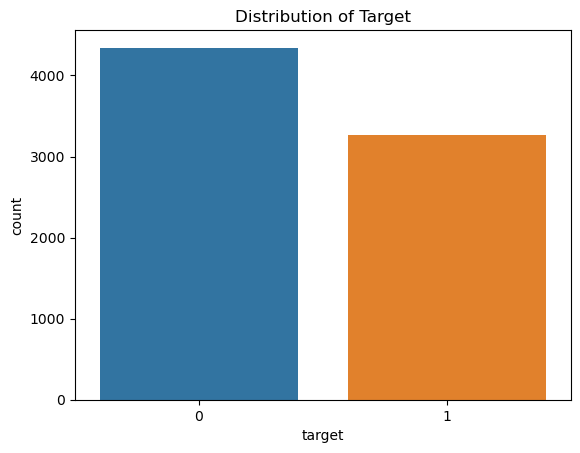

In [270]:
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target')
plt.show()

Here is a histogram of text length of tweets:

<Axes: >

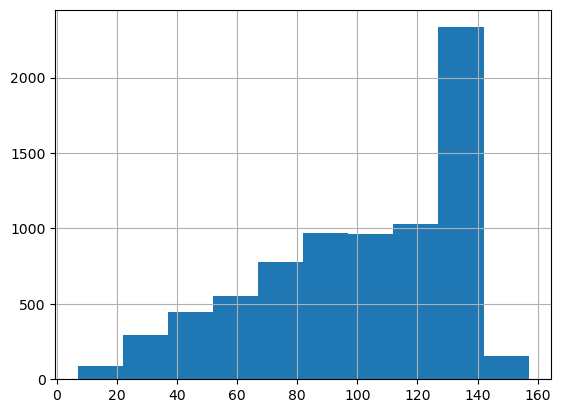

In [271]:
df_train['text'].str.len().hist()

### Data Cleaning
We will clean and prepare the text by removing stop words, converting to lower case, removing urls etc.

In [272]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/deniz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [273]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\-)*\b', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df_train["text"]= df_train["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(clean_text)

Check the first few rows after cleaning:

In [274]:
df_train.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,13 000 people receive wildfires evacuation ord...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1


### Extracting Word Features with TF-ID
To process text into matrix form we will use TF-IDF. TF-IDF stands for Term Frequency Inverse Document Frequency of records. It is a measure of importance of a word to a document adjusted for how frequent that word occurs in general. Here we are going to use TfidVectorizer from sklearn.
Later for RNN we will use its Keras' encoder.

In [275]:
train_list = df_train["text"].tolist()
y = df_train["target"]

vectorizer = TfidfVectorizer(min_df = 0.0005, 
                             max_features = 10000, 
                             ngram_range = (1,4))

vec_fit = vectorizer.fit(train_list)

train = vec_fit.transform(df_train["text"])


Split the data into training and validation sets:

In [276]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.2 , random_state=42)

X_test = vec_fit.transform(df_test["text"])


# Modeling
Before developing our deep learning model we will take a look at a Logistic Regression Model so that we have something to compare to. Then we will try an RNN model with LTSM. Later we will use hyperparameter tuning to see if we can improve on our RNN model. 

## Logistic Regression Model for Baseline comparison
Before we start with our RNN model we will train a simple Logistic Regression model for baseline comparison. 

In [277]:
lr_model = LogisticRegression(C = 1, penalty = 'l2')

lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_val)
print("Logistic Regression Model Validation Acuracy", accuracy_score(y_val, lr_pred))
print("Logistic Regression Model Validation F1", f1_score(y_val, lr_pred))

Logistic Regression Model Validation Acuracy 0.8017071569271176
Logistic Regression Model Validation F1 0.7495854063018242


We achieved 0.80 accuracy with Logistic Regression.

## RNN Model First Try
For our RNN model, we will closely follow the architecture in the article "Text classification with an RNN" https://www.tensorflow.org/text/tutorials/text_classification_rnn

This picture is from above mentioned article:

<img src="https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png" alt="bidirectional" class="bg-primary mb-1" width="500px">

* The model is build as a tf.keras.Sequential
* The first layer is the encoder, which converts the text to a sequence of token indices.
* After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.
* A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.
* The tf.keras.layers.Bidirectional wrapper is used with RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
* After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single classification output.

The only thing changed in this model from tensorflow article is that adding sigmoid activation to the last Dense layer for binary classification output.



### Converting Data into TensorFlow Format
We will also need convert our pandas data frames into tensorflow format. This article was helpful for preparing training, validation and test datasets for tensorflow: https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168

In [278]:
### Converting data into tensorflow format

# %80 of training data will be used as training set, %20 for validation
train_size = 0.8
n = df_train.shape[0]
ntrain = math.floor(train_size * n)
train_set = sample([i for i in range(n)], ntrain)
val_set = [i for i in range(n) if not i in train_set]

train = df_train.iloc[train_set]
valid = df_train.iloc[val_set]


# preparing datasets for tensorflow
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train["text"].values, tf.string),
            tf.cast(train["target"].values, tf.int32)
        )
    )
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(valid["text"].values, tf.string),
            tf.cast(valid['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_test["text"].values, tf.string)
        )
    )
)


### Create Batches of Text and Labels
We will shuffle the data for training and create batches of these (text, label) pairs:


In [279]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padding_values = ' ')


In [280]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2024-06-13 00:14:37.853155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Now we are finally ready for our RNN model:

In [281]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the model with Adam optimizer:

In [282]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train the model on the training data set:

In [283]:
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

history = model.fit(train_dataset, epochs = 6,
                    validation_data = validation_dataset,
                    callbacks = callbacks_list,
                    verbose = 1)

Epoch 1/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.5312 - loss: 0.6891 - val_accuracy: 0.5752 - val_loss: 0.6749
Epoch 2/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5633 - loss: 0.6747 - val_accuracy: 0.6185 - val_loss: 0.6495
Epoch 3/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.6499 - loss: 0.6251 - val_accuracy: 0.7459 - val_loss: 0.5286
Epoch 4/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7738 - loss: 0.4961 - val_accuracy: 0.7938 - val_loss: 0.4592
Epoch 5/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8072 - loss: 0.4353 - val_accuracy: 0.7938 - val_loss: 0.4552
Epoch 6/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.8196 - loss: 0.4140 - val_accuracy: 0.7932 - val_loss: 0.4527


### First RNN Model Evaluation

Accuracy on the validation data set is 0.7924

In [297]:
test_loss, test_acc = model.evaluate(validation_dataset)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.7924 - loss: 0.4470


#### Accuracy and Loss Plots for Training and Validation

<function matplotlib.pyplot.show(close=None, block=None)>

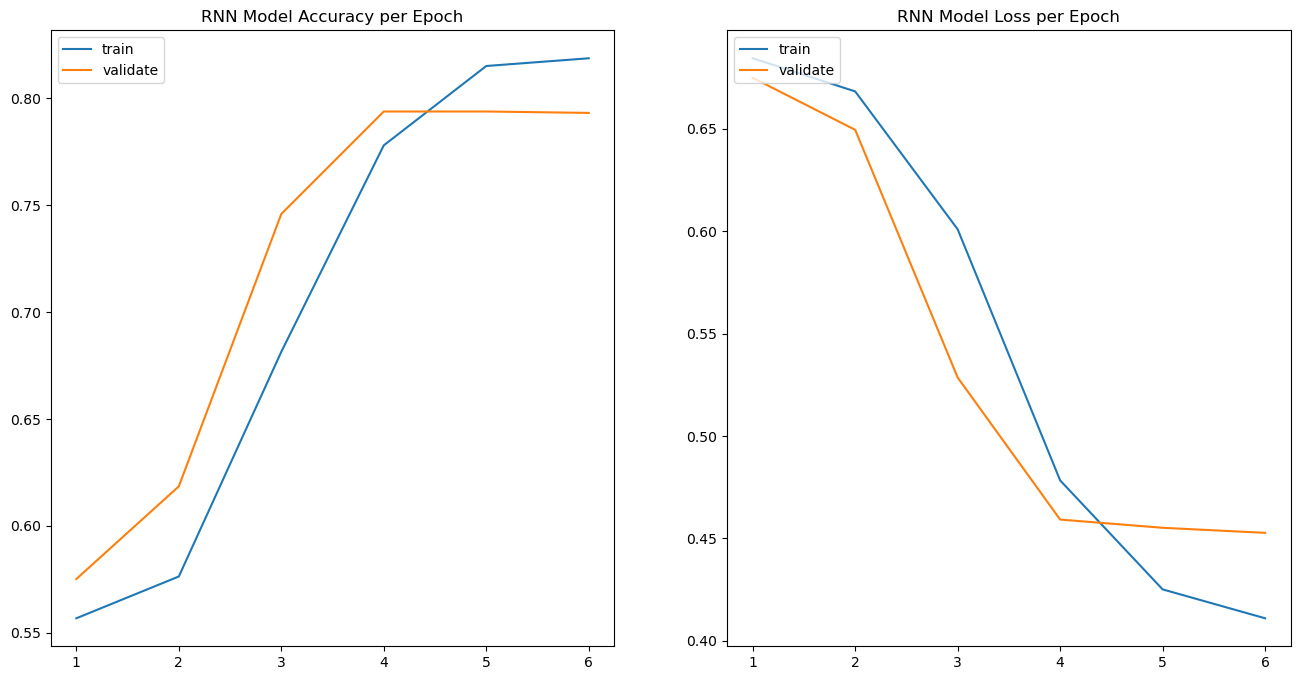

In [298]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('RNN Model Accuracy per Epoch')
plt.plot(np.arange(1,len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(np.arange(1,len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.legend(['train', 'validate'], loc='upper left')

plt.subplot(1, 2, 2)
plt.title('RNN Model Loss per Epoch')
plt.plot(np.arange(1,len(history.history['loss']) + 1), history.history['loss'])
plt.plot(np.arange(1,len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.legend(['train', 'validate'], loc='upper left')
plt.show

As can bee seen in the above plots, after 4 epochs accuracy for validation set levels off.

## RNN Model Improvement 
We will try improving our RNN Model's architecture by stacking more LTSM layers.

According to "Text classification with an RNN article" at https://www.tensorflow.org/text/tutorials/text_classification_rnn:

Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

* If False it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If True the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

Image from article for return_sequences=True:

<img src="https://www.tensorflow.org/static/text/tutorials/images/layered_bidirectional.png" alt="layered" class="bg-primary mb-1" width="500px">

We will try stacking LTSM layers. We will also try Dropouts and decide on roughly how many LTSM layers as a function of our dropout rate.


### Hyperparameter Tuning
We will perform hyperparameter tuning using keras_tuner. First we will define the hyperparameters to try. We will try different values for number of units, dropout values and learning rates. We will keep activation relu and optimizer adam to save time, however this code still takes considerable time.

In [286]:
tf.random.set_seed(42)

# Define the hyperparameters
hp = keras_tuner.HyperParameters()

hp.Int('n_units', 32, 64, 128)
hp.Choice('activation', ['relu'])
hp.Choice('optimizer', ['adam'])
hp.Choice('dropout', [0.2, 0.5])
hp.Choice('learning_rate', [0.00001 , 0.0001, 0.001])

# Define the model builder function to pass to RandomSearch
def build_model(hp):
    new_model = keras.models.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim= hp.get('n_units'),
            # masking to handle the variable sequence lengths
            mask_zero=True)])

    ## Hidden Layers 
    # calculate number of hidden layers by dividing 1 (from original model) by dropout rate -1
    n_hidden = math.floor(1 / hp.get('dropout')) - 1
    for hlayer in range(n_hidden):
        new_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.get('n_units'), return_sequences=True)))
    new_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.get('n_units'))))  
    new_model.add(keras.layers.Dense(units=hp.get('n_units'), activation = hp.get('activation')))
    new_model.add(Dropout(hp.get('dropout')))        

    # output layer
    new_model.add(keras.layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate = hp.get('learning_rate'))

    new_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return new_model


We will use keras tuner RandomSearch for hyperparameter tuning.

In [288]:
# Create the Keras Tuner search space
krs_tuner = keras_tuner.RandomSearch(build_model, hyperparameters=hp, objective='val_accuracy', max_trials=10)

# Fit the tuner to the data
krs_tuner.search(train_dataset, epochs = 6, 
             validation_data=validation_dataset,
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# Get the best model
best_model = krs_tuner.get_best_models(num_models=1)[0]

Trial 6 Complete [00h 03m 24s]
val_accuracy: 0.8030203580856323

Best val_accuracy So Far: 0.8082731366157532
Total elapsed time: 00h 37m 12s


In [289]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_7            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 32)       │        32,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,081 (586.25 KB)

 Trainable params: 150,081 (586.25 KB)

 Non-trainable params: 0 (0.00 B)

In [290]:
krs_tuner.oracle.get_best_trials(num_trials=1)[0].summary()

Trial 03 summary
Hyperparameters:
n_units: 32
activation: relu
optimizer: adam
dropout: 0.2
learning_rate: 0.001
Score: 0.8082731366157532


### Decaying Learning Rate
We will try decaying the learning rate as a final improvement attempt. 

In [291]:
learning_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 1000,
    decay_rate = 0.96, 
    staircase = True
) 

In [292]:
final_model = keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32),        
    ## Hidden Layers 
    # use_cudnn needs to be False when using masking needs to be set to False
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(62, return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, use_cudnn=False)), 
    
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),        
    
    # output layer
    keras.layers.Dense(1, activation='sigmoid')])

opt = tf.keras.optimizers.Adam(learning_rate = learning_schedule)

final_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Fit and train our model with the training data set:

In [293]:
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

final_history = final_model.fit(train_dataset, epochs = 5,
                    validation_data = validation_dataset,
                    callbacks = callbacks_list,
                    verbose = 1)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 108s 968ms/step - accuracy: 0.6114 - loss: 0.6468 - val_accuracy: 0.7827 - val_loss: 0.4979
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 778ms/step - accuracy: 0.8078 - loss: 0.4451 - val_accuracy: 0.8004 - val_loss: 0.4516
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 757ms/step - accuracy: 0.8191 - loss: 0.4186 - val_accuracy: 0.8030 - val_loss: 0.4578
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 780ms/step - accuracy: 0.8279 - loss: 0.4040 - val_accuracy: 0.8030 - val_loss: 0.4499
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 791ms/step - accuracy: 0.8493 - loss: 0.3714 - val_accuracy: 0.8063 - val_loss: 0.4545


### Final RNN Model Evaluation
Validation accuracy of our final model is 0.8066

In [294]:
val_loss, val_acc = final_model.evaluate(validation_dataset)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.8066 - loss: 0.4489


### Accuracy and Loss Plots for Training and Validation

<function matplotlib.pyplot.show(close=None, block=None)>

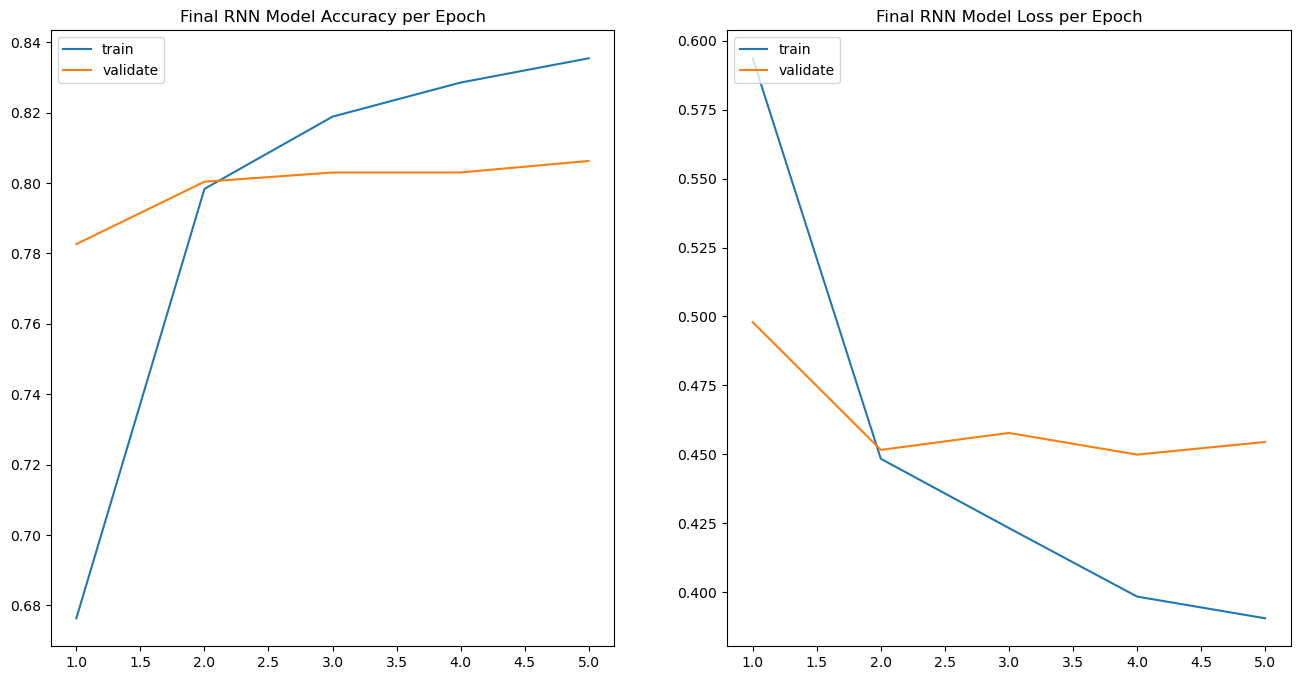

In [295]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Final RNN Model Accuracy per Epoch')
plt.plot(np.arange(1,len(final_history.history['accuracy']) + 1), final_history.history['accuracy'])
plt.plot(np.arange(1,len(final_history.history['val_accuracy']) + 1), final_history.history['val_accuracy'])
plt.legend(['train', 'validate'], loc='upper left')

plt.subplot(1, 2, 2)
plt.title('Final RNN Model Loss per Epoch')
plt.plot(np.arange(1,len(final_history.history['loss']) + 1), final_history.history['loss'])
plt.plot(np.arange(1,len(final_history.history['val_loss']) + 1), final_history.history['val_loss'])
plt.legend(['train', 'validate'], loc='upper left')
plt.show

After epoch 2 validation accuracy leveled off.

### Prepare for Submission
We will prepare test results for kaggle submission.

In [299]:
y_final = final_model.predict(test_dataset)
y_final = y_final.reshape(y_final.shape[0], )
y_final = y_final.tolist()
predictions = [round(y_final[i]) for i in range(len(y_final))]
submission_df = pd.DataFrame({'id': df_test['id'], 'target': predictions})
submission_df.to_csv("submission.csv", index = False)

51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step


## Results
Submission of final results to kaggle resulted in a score of 0.79.

Accuracy of our models on the validation set can be seen in the table below:
| Logistic Regression | RNN  | RNN with hyperparameter tuning | RNN with learning rate decay |
|---------------------|------|--------------------------------|------------------------------|
| 0.80                | 0.79 | 0.81                           | 0.81                         |
                              
There is hardly any difference in validation accuracy between our models.

Hyperparameter optimization procedure resulted in following hyperparameter values:

| hyperparameter | value |
|----------------|-------|
| number of units| 32    |
| activation     | relu  |
| optimizer      | adam  |
| dropout        | 0.2   |
| learning rate  | 0.001 |

For our final model we used the hyperparameters from the best model we found during hyperparamater search and added learning rate decay. 


## Conclusion 
After all the hyperparameter tuning, decaying learning rate, bidirectional return sequences etc our final RNN model did not surpass simple Logistic Regression accuracy. This could be due to the fact that tweets are simply not reliable predictors of disasters, it may be that this is about as good as it gets as far as predictive power of tweet texts. It is also quite possible that given extra time and effort better architectural choices can be made. Considering that it takes such a long time to tune hyperparameters we would need very long time to try out a more exhaustive combination of hyperparameters. 

BERT or DistilBert could perform better, however support on Mac was dismal. These or other architectural choices like GRU can be explored in the future. 

### References:
* https://www.tensorflow.org/text/tutorials/text_classification_rnn
* https://medium.com/@upendravijay2/how-does-dropout-help-to-avoid-overfitting-in-neural-networks-91b90fd86b20
* https://www.tensorflow.org/guide/keras/working_with_rnns
* https://www.tensorflow.org/tutorials/keras/keras_tuner
* https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168